# General Model Selection and Evaluation

This code is dedicated to understanding which models will be better for classification of data extracted from the LIDC-IDRI dataset.

The `model_evaluation` function shown below serves as a generalized accuracy test across various models. This function has undergone numerous modifications throughout the testing phase, culminating in its current, final iteration. In `report.ipynb`, the specific models employed will undergo further training and parameterization in separate **.py files**, for ease of access in the stacking process.

The `.csv` files employed in this version contain **clean and analyzed** datasets, derived from the raw data using the `pylidc`, `pyradiomics`, and deep feature extraction methods.

Additionally, we will be testing performance on the `LungX` dataset.

The relevant analysis and cleanup methods can be found in the **csv_manipulation** folder.

## Importing libraries and Datasets

We will begin by importing the relevant and necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

Next, we will convert the datasets into pandas DataFrames for further processing.

In [2]:
df = pd.read_csv('lidc_rfe50.csv')
df.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,2,0.339816,0.562524,0.442979,0.730204,0.333658,0.491633,0.398934,0.413691,0.399483,...,0.364344,0.011082,0.001734,0.648394,0.005157,0.210980,0.878810,0.157930,0.324954,0.496851
1,2,0.526288,0.736178,0.486639,0.796184,0.340574,0.547593,0.475688,0.532664,0.690380,...,0.161537,0.034874,0.000000,0.359984,0.000511,0.465737,0.890961,0.364065,0.240920,0.253756
2,0,0.616598,0.428909,0.104794,0.619367,0.502572,0.125043,0.291206,0.484636,0.376556,...,0.224852,0.000876,0.000000,0.610007,0.002463,0.448261,0.874003,0.314858,0.249673,0.428741
3,2,0.395332,0.431717,0.251262,0.735690,0.667631,0.282189,0.237252,0.245101,0.460938,...,0.368496,0.004530,0.004242,0.659629,0.006736,0.313686,0.804823,0.218568,0.269539,0.537671
4,1,0.432535,0.491978,0.446434,0.571172,0.847354,0.442363,0.294933,0.210586,0.340075,...,0.570872,0.018355,0.163190,0.800094,0.029328,0.247511,0.736251,0.118588,0.323211,0.432529


After that, we need to split the features and target variable. We will also be using 10-fold cross validation for every model.

In [3]:
X = df.drop(columns=['is_cancer'])  
y = df['is_cancer']  

We decided to use Stratified K-Folds, since it ensures that each fold has the same class balance as the whole dataset.

This is especially useful for imbalanced data, because each fold fairly represents all classes, in contrast with the regular K-Folds, which can create folds that miss certain classes due to said imbalance.

In [4]:
def model_evaluation(X, y):
    
    # Collection of models we wish to test
    models = {
        'Logistic Regression': LogisticRegression(max_iter=700),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'XGBoost': XGBClassifier(eval_metric='mlogloss'),
        'SVM': SVC(kernel='rbf'),
        'Gaussian Naive Bayes': GaussianNB()
    }
    
    # Defines 10-fold cross-validation (preserving class distribution)
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    
    # Trains and evaluates all models in the collection above
    for name, model in models.items():
        accuracies = []
        misclass_percentages = []  

        for train_index, test_index in skf.split(X, y):
            
            # Use iloc to select by position
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fits and tests the model
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            accuracies.append(accuracy)
            
            # Save misclassification percentage for each class
            confusion = confusion_matrix(y_test, predictions)
            class_errors = []
            
            # Calculates percentages using values obtained with confusion matrix (TP, FP, FN, TN)
            for i, class_total in enumerate(confusion.sum(axis=1)):
                if class_total > 0:
                    misclassified = class_total - confusion[i, i]  
                    misclass_percentage = (misclassified / class_total) * 100
                else:
                    misclass_percentage = 0.0
                class_errors.append(misclass_percentage)
            
            misclass_percentages.append(class_errors)
        
        # Calculate mean accuracy and mean misclassification percentages per class
        # (mean in necessary due to the use of K-folds)
        mean_accuracy = np.mean(accuracies)
        mean_misclass_percentages = np.mean(misclass_percentages, axis=0)
        
        # Displays results for each model
        print(f"{name} Mean Accuracy: {mean_accuracy:.2f}")
        for i, error in enumerate(mean_misclass_percentages):
            print(f"Class {i} Mean Misclassification Percentage: {error:.2f}%")
        print()


In [5]:
print("For reference:\n Class 0: not cancer\n Class 1: ambiguous\n Class 2: cancer\n")

model_evaluation(X,y)

For reference:
 Class 0: not cancer
 Class 1: ambiguous
 Class 2: cancer

Logistic Regression Mean Accuracy: 0.60
Class 0 Mean Misclassification Percentage: 73.36%
Class 1 Mean Misclassification Percentage: 18.73%
Class 2 Mean Misclassification Percentage: 45.35%

Random Forest Mean Accuracy: 0.58
Class 0 Mean Misclassification Percentage: 73.35%
Class 1 Mean Misclassification Percentage: 20.61%
Class 2 Mean Misclassification Percentage: 47.80%

XGBoost Mean Accuracy: 0.58
Class 0 Mean Misclassification Percentage: 65.35%
Class 1 Mean Misclassification Percentage: 27.09%
Class 2 Mean Misclassification Percentage: 46.05%

SVM Mean Accuracy: 0.58
Class 0 Mean Misclassification Percentage: 87.14%
Class 1 Mean Misclassification Percentage: 12.68%
Class 2 Mean Misclassification Percentage: 47.49%

Gaussian Naive Bayes Mean Accuracy: 0.50
Class 0 Mean Misclassification Percentage: 50.17%
Class 1 Mean Misclassification Percentage: 57.71%
Class 2 Mean Misclassification Percentage: 18.13%



Considering that our accuracy was unexpectedly low, we decided to convert the dataset into a binary classification problem. 

We believe that this issue may rise from a **combination of class imbalance and class overlap**, and we consider that transforming to a binary classification problem could potentially improve model performance.

In order to quickly check class overlap, we decided to observe a few features' scatterplots:

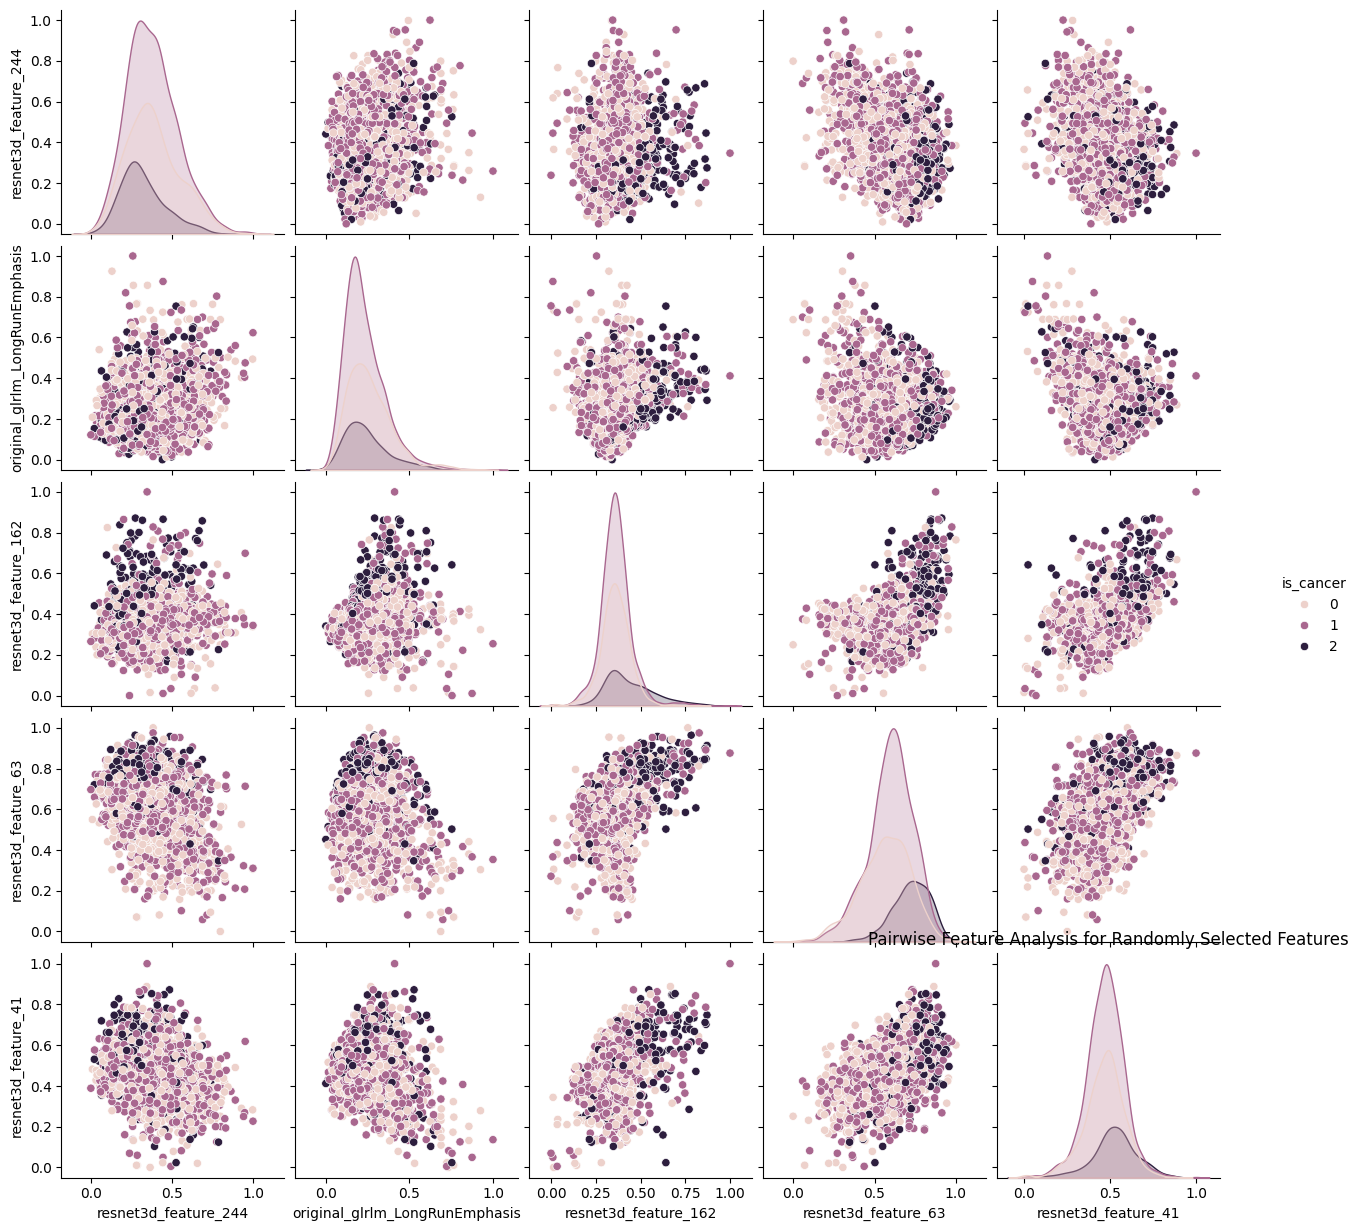

In [8]:
import random

# Assuming df is your DataFrame and has at least 10 feature columns
# Get the feature columns (excluding 'is_cancer')
feature_columns = df.columns.difference(['is_cancer']).tolist()

# Randomly select 5 columns (you can adjust this back to 10 if needed)
random_columns = random.sample(feature_columns, 5)  # Randomly select 5 features

# Create a pairplot for the selected random columns
sns.pairplot(df[random_columns + ['is_cancer']], hue='is_cancer')
plt.title('Pairwise Feature Analysis for Randomly Selected Features')

# Save the plot as a PNG file
plt.savefig('pairwise_feature_analysis.png', dpi=300)  # dpi=300 for high resolution

plt.show()

In [19]:
# Removes ambiguous option
df_rem = df.copy()
before = df_rem.shape[0] # n_linhas antes

mask = df_rem['is_cancer'] == 1
df_rem = df_rem[~mask]
after = df_rem.shape[0] # n_linhas depois

df_rem['is_cancer'] = df_rem['is_cancer'].replace(2, 1)
print(f"Row size changed from {before} to {after} (lost {before-after} rows).")

# Mostrar diferença no número de linhas quando removemos casos ambíguos

# Maps ambiguous values to cancer or not cancer
df_amb_cancer = df.copy()
df_amb_not_cancer = df.copy()

# Mapeamento necessário para trees (expected 0 and 1)
df_amb_cancer['is_cancer'] = df_amb_cancer['is_cancer'].replace(2, 1)
df_amb_not_cancer['is_cancer'] = df_amb_not_cancer['is_cancer'].replace({1: 0, 2: 1})

Row size changed from 2626 to 1238 (lost 1388 rows).


In [20]:
df_rem.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,1,0.339816,0.562524,0.442979,0.730204,0.333658,0.491633,0.398934,0.413691,0.399483,...,0.364344,0.011082,0.001734,0.648394,0.005157,0.210980,0.878810,0.157930,0.324954,0.496851
1,1,0.526288,0.736178,0.486639,0.796184,0.340574,0.547593,0.475688,0.532664,0.690380,...,0.161537,0.034874,0.000000,0.359984,0.000511,0.465737,0.890961,0.364065,0.240920,0.253756
2,0,0.616598,0.428909,0.104794,0.619367,0.502572,0.125043,0.291206,0.484636,0.376556,...,0.224852,0.000876,0.000000,0.610007,0.002463,0.448261,0.874003,0.314858,0.249673,0.428741
3,1,0.395332,0.431717,0.251262,0.735690,0.667631,0.282189,0.237252,0.245101,0.460938,...,0.368496,0.004530,0.004242,0.659629,0.006736,0.313686,0.804823,0.218568,0.269539,0.537671
6,0,0.275632,0.454981,0.361014,0.542304,0.659543,0.325105,0.451855,0.178754,0.195805,...,0.453218,0.008320,0.354365,0.870931,0.072326,0.308885,0.574462,0.183526,0.196528,0.378695


In [21]:
df_amb_cancer.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,1,0.339816,0.562524,0.442979,0.730204,0.333658,0.491633,0.398934,0.413691,0.399483,...,0.364344,0.011082,0.001734,0.648394,0.005157,0.210980,0.878810,0.157930,0.324954,0.496851
1,1,0.526288,0.736178,0.486639,0.796184,0.340574,0.547593,0.475688,0.532664,0.690380,...,0.161537,0.034874,0.000000,0.359984,0.000511,0.465737,0.890961,0.364065,0.240920,0.253756
2,0,0.616598,0.428909,0.104794,0.619367,0.502572,0.125043,0.291206,0.484636,0.376556,...,0.224852,0.000876,0.000000,0.610007,0.002463,0.448261,0.874003,0.314858,0.249673,0.428741
3,1,0.395332,0.431717,0.251262,0.735690,0.667631,0.282189,0.237252,0.245101,0.460938,...,0.368496,0.004530,0.004242,0.659629,0.006736,0.313686,0.804823,0.218568,0.269539,0.537671
4,1,0.432535,0.491978,0.446434,0.571172,0.847354,0.442363,0.294933,0.210586,0.340075,...,0.570872,0.018355,0.163190,0.800094,0.029328,0.247511,0.736251,0.118588,0.323211,0.432529


In [22]:
df_amb_not_cancer.head()

,is_cancer,resnet3d_feature_33,resnet3d_feature_41,resnet3d_feature_52,resnet3d_feature_63,resnet3d_feature_64,resnet3d_feature_66,resnet3d_feature_67,resnet3d_feature_68,resnet3d_feature_72,...,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunEmphasis
0,1,0.339816,0.562524,0.442979,0.730204,0.333658,0.491633,0.398934,0.413691,0.399483,...,0.364344,0.011082,0.001734,0.648394,0.005157,0.210980,0.878810,0.157930,0.324954,0.496851
1,1,0.526288,0.736178,0.486639,0.796184,0.340574,0.547593,0.475688,0.532664,0.690380,...,0.161537,0.034874,0.000000,0.359984,0.000511,0.465737,0.890961,0.364065,0.240920,0.253756
2,0,0.616598,0.428909,0.104794,0.619367,0.502572,0.125043,0.291206,0.484636,0.376556,...,0.224852,0.000876,0.000000,0.610007,0.002463,0.448261,0.874003,0.314858,0.249673,0.428741
3,1,0.395332,0.431717,0.251262,0.735690,0.667631,0.282189,0.237252,0.245101,0.460938,...,0.368496,0.004530,0.004242,0.659629,0.006736,0.313686,0.804823,0.218568,0.269539,0.537671
4,0,0.432535,0.491978,0.446434,0.571172,0.847354,0.442363,0.294933,0.210586,0.340075,...,0.570872,0.018355,0.163190,0.800094,0.029328,0.247511,0.736251,0.118588,0.323211,0.432529


Let's try again:

In [23]:
X_cancer = df_amb_cancer.drop(columns=['is_cancer'])  
y_cancer = df_amb_cancer['is_cancer']  

X_not = df_amb_not_cancer.drop(columns=['is_cancer'])  
y_not = df_amb_not_cancer['is_cancer'] 

X_bin = df_rem.drop(columns=['is_cancer'])  
y_bin = df_rem['is_cancer']  

In [24]:
warnings.filterwarnings('ignore')

print("For reference:\n Class 0: not cancer\n Class 1: ambiguous + cancer\n")

model_evaluation(X_cancer,y_cancer)
print("------------------------------------------")

print("For reference:\n Class 0: not cancer + ambiguous\n Class 1: cancer\n")

model_evaluation(X_not,y_not)
print("------------------------------------------")

print("For reference:\n Class 0: not cancer\n Class 1: cancer\n")
model_evaluation(X_bin,y_bin)

For reference:
 Class 0: not cancer
 Class 1: ambiguous + cancer

Logistic Regression Mean Accuracy: 0.68
Class 0 Mean Misclassification Percentage: 75.44%
Class 1 Mean Misclassification Percentage: 10.49%

Random Forest Mean Accuracy: 0.67
Class 0 Mean Misclassification Percentage: 76.01%
Class 1 Mean Misclassification Percentage: 11.57%

XGBoost Mean Accuracy: 0.67
Class 0 Mean Misclassification Percentage: 66.51%
Class 1 Mean Misclassification Percentage: 16.16%

SVM Mean Accuracy: 0.67
Class 0 Mean Misclassification Percentage: 92.35%
Class 1 Mean Misclassification Percentage: 3.68%

Gaussian Naive Bayes Mean Accuracy: 0.62
Class 0 Mean Misclassification Percentage: 37.65%
Class 1 Mean Misclassification Percentage: 37.84%

------------------------------------------
For reference:
 Class 0: not cancer + ambiguous
 Class 1: cancer

Logistic Regression Mean Accuracy: 0.90
Class 0 Mean Misclassification Percentage: 3.51%
Class 1 Mean Misclassification Percentage: 51.75%

Random Forest 

# Summary of Findings

Removing ambiguity from the dataset seems to improve cancer prediction performance:

The accuracy of the models significantly improved when ambiguous cases were classified as "not cancer." We understand this **"improvement"** ocurred due to an imbalance in class distributions, where "not cancer" and "ambiguous" (and their combination) cases constitute the largest portion of the data. 

Such an imbalance lead to overfitting of the **0** (`not cancer + ambiguous`) class, compromising the model’s generalizability to less common classes.

We can confirm this by examining the **Class 1 Mean Misclassification Percentage** (`cancer`) values across nearly all the models above. The results indicate that only a minimal percentage of `not cancer + ambiguous` cases were misclassified, whereas the other class displays a considerably higher misclassification rate (~50%).

The only model demonstrating more generalized performance was the Gaussian Naive Bayes (NB), with a misclassification rate of approximately 23% for class 0 and 17% for class 1. Although this model achieved a **lower overall accuracy**, it **demonstrates a more balanced classification** across classes.


For all the reasons mentioned above, we **do not recommend excluding ambiguous cases**.

Our rationale is that if there is uncertainty regarding a cancer diagnosis (and even the AI model is uncertain), it is in the patient’s best interest for a professional to recommend further testing, rather than assuming they are cancer-free based solely on achieving higher accuracy.

This is a significant observation, as failing to detect actual cancer cases (simply because the models achieve higher accuracy values), could have serious clinical implications.

## Next Step

Following a general analysis of **potential data issues** and **promising models**, we will now create individual models in separate `.py` files. 

This approach will support the development of a final model using stacking, **designed to address these challenges** and **classify** the datasets with performance that can keep up with the requested standards.